## Dev du DL Model (LSTM avec PSO)

In [1]:
#importation des bibs
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from pyswarm import pso
import matplotlib.pyplot as plt

# Load dataset
path = r"C:\Users\VECTUS\DL_For_SOC_Estimation\datasets\processed_data.csv"
data = pd.read_csv(path)  

# Select features and target
features = ['Courant', 'Tension', 'Cellule_min', 'Cellule_max', 'Temp1', 'Temp4']
target = 'SOC'


# Create sequences for LSTM
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_seq, y_seq = create_sequences(X, y, time_steps)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [2]:
def create_lstm_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Initial model for testing
model = create_lstm_model()
model.summary()

C:\Users\VECTUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from keras.optimizers import Adam
# Define the search space for PSO
lb = [10, 0.1, 10]  # lower bounds for [units, dropout_rate, learning_rate]
ub = [200, 0.5, 100]  # upper bounds

# Define the objective function for PSO
def objective_function(x):
    units = int(x[0])
    dropout_rate = x[1]
    learning_rate = x[2] / 10000  # scaling learning rate
    
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, 
                        validation_split=0.2, verbose=1)
    
    # Return validation loss
    return min(history.history['val_loss'])

# Run PSO optimization
xopt, fopt = pso(objective_function, lb, ub, swarmsize=10, maxiter=20)

print("Optimal parameters:")
print(f"Units: {int(xopt[0])}")
print(f"Dropout rate: {xopt[1]:.3f}")
print(f"Learning rate: {xopt[2]/10000:.5f}")

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0609 - val_loss: 0.0015
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0058 - val_loss: 0.0020
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0043 - val_loss: 0.0259
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0218 - val_loss: 0.0028
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0089 - val_loss: 0.0011
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 0.0052
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0048 - val_loss: 9.6632e-04
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0053 - val_loss: 8.2983e-04
Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0737 - val_loss: 0.0061
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - los

In [6]:
from keras.optimizers import Adam

# Get optimized parameters
optimal_units = int(xopt[0])
optimal_dropout = xopt[1]
optimal_lr = xopt[2] / 10000



In [10]:
# Create final model
from keras.callbacks import EarlyStopping

final_model = Sequential()
final_model.add(LSTM(units=optimal_units, return_sequences=True, 
                    input_shape=(X_train.shape[1], X_train.shape[2])))
final_model.add(Dropout(optimal_dropout))
final_model.add(LSTM(units=optimal_units))
final_model.add(Dropout(optimal_dropout))
final_model.add(Dense(1))

final_model.compile(optimizer=Adam(learning_rate=optimal_lr), loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,       
    restore_best_weights=True, 
    verbose=1
)

# Train the model with early stopping
history = final_model.fit(
    X_train, 
    y_train, 
    epochs=50,           # Maximum number of epochs (training will stop earlier due to early stopping)
    batch_size=32, 
    validation_split=0.2,
    callbacks=[early_stopping],  # Add the early stopping callback
    verbose=1
)

# Print the number of epochs actually run
print(f"Training stopped after {len(history.history['loss'])} epochs")



Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0606 - val_loss: 0.0066
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0147 - val_loss: 0.0023
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0071 - val_loss: 0.0010
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058 - val_loss: 0.0018
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0046 - val_loss: 8.2173e-04
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0036 - val_loss: 9.6134e-04
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0063 - val_loss: 8.3135e-04
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0055 - val_loss: 0.0017
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step 

            Model Performance Metrics             
Mean Squared Error (MSE)      : 0.0734
Root Mean Squared Error (RMSE): 0.2710
R-squared (R²)                : 0.9942



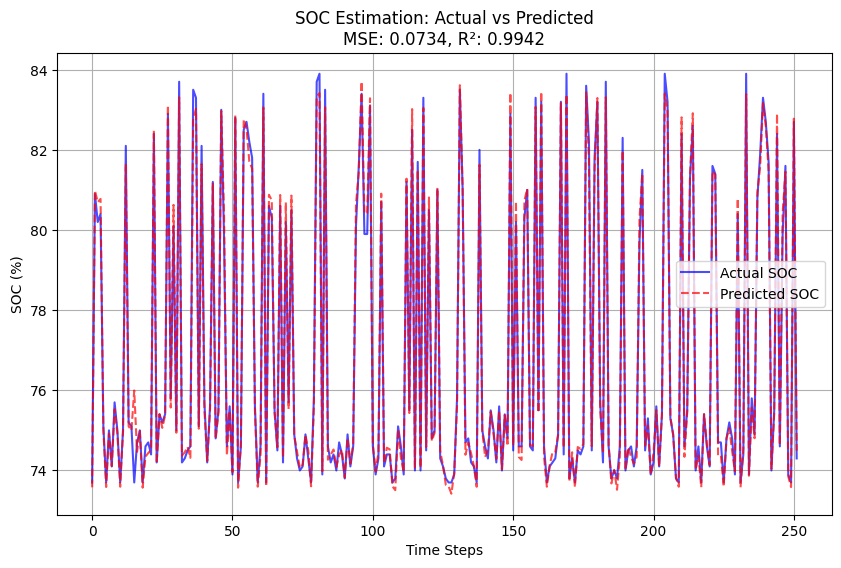

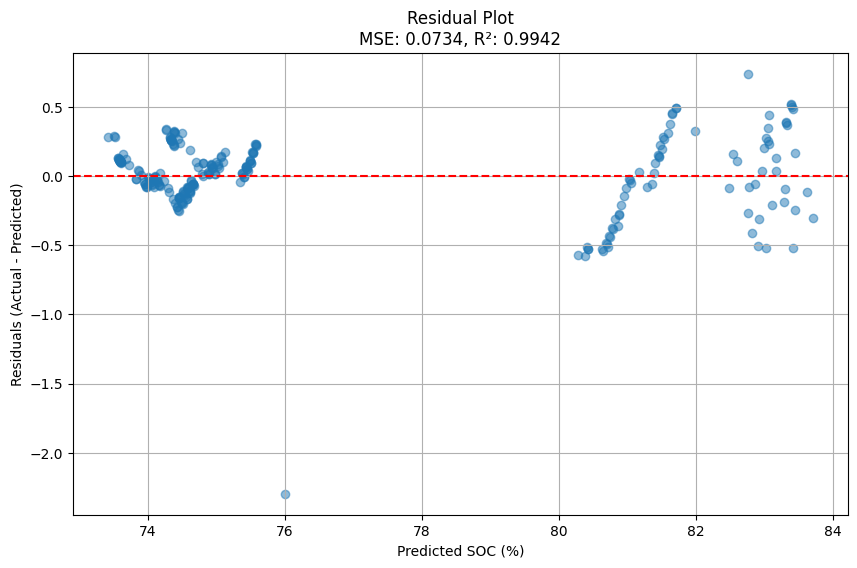

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred = final_model.predict(X_test)

# Inverse transform to get actual values (if you scaled your data)
y_test_inv = scaler_target.inverse_transform(y_test)
y_pred_inv = scaler_target.inverse_transform(y_pred)

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

# Create a nice display of the metrics
print("\n" + "="*50)
print("Model Performance Metrics".center(50))
print("="*50)
print(f"{'Mean Squared Error (MSE)':<30}: {mse:.4f}")
print(f"{'Root Mean Squared Error (RMSE)':<30}: {rmse:.4f}")
print(f"{'R-squared (R²)':<30}: {r2:.4f}")
print("="*50 + "\n")

# Visual comparison of actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual SOC', color='blue', alpha=0.7)
plt.plot(y_pred_inv, label='Predicted SOC', color='red', linestyle='--', alpha=0.7)
plt.title('SOC Estimation: Actual vs Predicted\nMSE: {:.4f}, R²: {:.4f}'.format(mse, r2))
plt.xlabel('Time Steps')
plt.ylabel('SOC (%)')
plt.legend()
plt.grid(True)
plt.show()

# Residual plot
residuals = y_test_inv - y_pred_inv
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_inv, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot\nMSE: {:.4f}, R²: {:.4f}'.format(mse, r2))
plt.xlabel('Predicted SOC (%)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

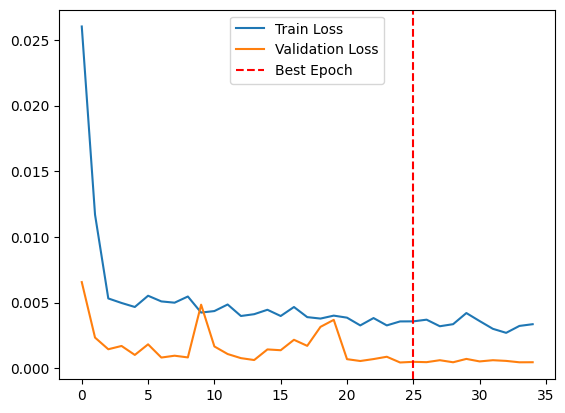

In [12]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(x=25, color='r', linestyle='--', label='Best Epoch')
plt.legend()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


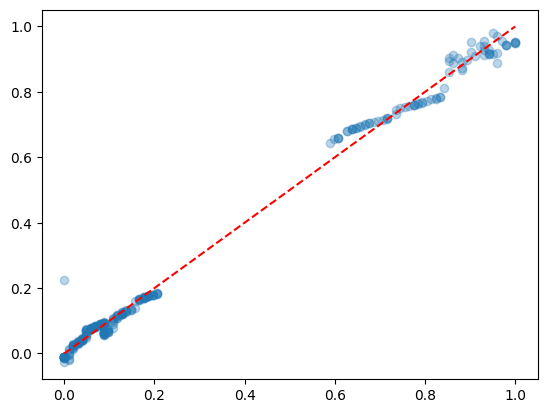

In [13]:
y_pred = final_model.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')

In [14]:
test_loss = final_model.evaluate(X_test, y_test)
print(f"Test MSE: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
Test MSE: 0.0007


In [15]:
from keras.models import save_model

# Sauvegarde du modèle
path_to = r"C:\Users\VECTUS\DL_For_SOC_Estimation\saved_model\lstm_battery_soc_model.h5"
save_model(final_model, path_to)
print("Modèle sauvegardé avec succès sous 'lstm_battery_soc_model.h5'")

Modèle sauvegardé avec succès sous 'lstm_battery_soc_model.h5'


In [16]:
# tester le modele sur des donnees independantes
import numpy as np

# Données brutes (simulées)
new_samples = np.array([
    # Format: [Courant, Tension, Cellule_min, Cellule_max, Temp1, Temp4]
    [15.2, 378.0, 3930, 3945, 20.1, 19.3],  # Échantillon 1
    [8.5, 377.5, 3925, 3940, 20.0, 19.2],   # Échantillon 2
    [32.0, 385.0, 4020, 4035, 21.0, 20.1]   # Échantillon 3
])

# Normalisation avec les mêmes scalers que l'entraînement
X_new_normalized = scaler_features.transform(new_samples)

# Création de séquences (en dupliquant les samples pour time_steps=10)
X_test_seq = np.array([X_new_normalized] * 10).transpose(1, 0, 2)  # Shape (3, 10, 6)

# Prédiction
predictions = final_model.predict(X_test_seq)
predictions_actual = scaler_target.inverse_transform(predictions)

# Résultats
for i, pred in enumerate(predictions_actual):
    print(f"Échantillon {i+1} → SOC prédit : {pred[0]:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


C:\Users\VECTUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Échantillon 1 → SOC prédit : 74.22%
Échantillon 2 → SOC prédit : 74.19%
Échantillon 3 → SOC prédit : 78.94%


In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Charger le modèle et les scalers (si nécessaire)
# model = load_model('lstm_battery_soc_model.h5')
# scaler_features = ... (charger depuis votre entraînement)
# scaler_target = ... (charger depuis votre entraînement)

# 2. Données de test (3 échantillons)
new_samples = np.array([
    # [Courant, Tension, Cellule_min, Cellule_max, Temp1, Temp4]
    [15.2, 378.0, 3930, 3945, 20.1, 19.3],  # Échantillon 1
    [8.5, 377.5, 3925, 3940, 20.0, 19.2],   # Échantillon 2
    [32.0, 385.0, 4020, 4035, 21.0, 20.1]   # Échantillon 3
])

# Valeurs réelles simulées correspondantes
y_true = np.array([77.8, 74.5, 83.2])  # SOC réel pour chaque échantillon

# 3. Normalisation des données
X_new_normalized = scaler_features.transform(new_samples)
y_true_normalized = scaler_target.transform(y_true.reshape(-1, 1))

# 4. Création des séquences temporelles (time_steps=10)
def create_sequences(data, time_steps=10):
    sequences = []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:(i + time_steps)])
    return np.array(sequences)

# Pour 3 échantillons, nous dupliquons les données pour créer des séquences
X_test_seq = np.array([X_new_normalized] * 10).transpose(1, 0, 2)  # Shape (3, 10, 6)

# 5. Prédiction
predictions = final_model.predict(X_test_seq)
predictions_actual = scaler_target.inverse_transform(predictions)

# 6. Calcul des métriques
mse_normalized = mean_squared_error(y_true_normalized, predictions)
r2_normalized = r2_score(y_true_normalized, predictions)

mse_actual = mean_squared_error(y_true, predictions_actual)
r2_actual = r2_score(y_true, predictions_actual)

# 7. Affichage des résultats
print("\n==========================================")
print("           RÉSULTATS DE PRÉDICTION        ")
print("==========================================")
for i in range(3):
    print(f"Échantillon {i+1}:")
    #print(f"- SOC réel: {y_true[i]:.2f}%")
    print(f"- SOC prédit: {predictions_actual[i][0]:.2f}%")
    #print(f"- Erreur: {abs(y_true[i] - predictions_actual[i][0]):.2f}%")
    print("------------------------------------------")





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

           RÉSULTATS DE PRÉDICTION        
Échantillon 1:
- SOC prédit: 74.22%
------------------------------------------
Échantillon 2:
- SOC prédit: 74.19%
------------------------------------------
Échantillon 3:
- SOC prédit: 78.94%
------------------------------------------


C:\Users\VECTUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\VECTUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
